#### 1. 生成模拟数据集。

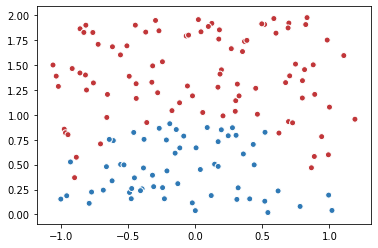

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1:
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.01)])
        label.append(1)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.01)])
        label.append(0)
        
data = np.hstack(data).reshape(-1,2)
label = np.hstack(label).reshape(-1).astype(np.float32)

plt.scatter(data[:,0], data[:,1], c=label,
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。

In [7]:
def get_weight(shape, lambda1):
    var = tf.Variable(tf.random_normal(shape,0.01), dtype=tf.float32, name="var")
    print(var)
    '''
    tf.contrib.layers.l1_regularizer(scale, scope=None)
    返回一个用来执行L1正则化的函数,函数的签名是func(weights).
    参数:

    scale: 正则项的系数.
    scope: 可选的scope name
    tf.contrib.layers.l2_regularizer(scale, scope=None)
    返回一个执行L2正则化的函数.

    tf.contrib.layers.sum_regularizer(regularizer_list, scope=None)
    返回一个可以执行多种(个)正则化的函数.意思是,创建一个正则化方法,这个方法是多个正则化方法的混合体.

    参数:
    regularizer_list: regulizer的列表
    '''
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var

#### 3. 定义神经网络。

In [8]:
x  = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, ))
sample_size = len(data)

# 每层节点的个数
# x=[none,2] 一个数据有两个feature
# w1=2x10 w2=10x5 w3=5x3 w4=3x1
layer_dimension = [2,10,5,3,1]
n_layers = len(layer_dimension)

cur_layer = x
in_dimension = layer_dimension[0]

# 循环生成网络结构
for i in range(1, n_layers):
    print(i)
    out_dimension = layer_dimension[i]
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
   # print("EEEEEEEEorror?  这里是elu还是relu？？？")
    cur_layer = tf.nn.relu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y = cur_layer

# 损失函数的定义。
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size

# 所有weights和非正则化的损失都放到一个collection中；
tf.add_to_collection('losses', mse_loss)
# 正则化loss将非正则化mse_loss + 加上所有weights的值
loss = tf.add_n(tf.get_collection('losses'))
print(mse_loss,loss)

1
<tf.Variable 'var:0' shape=(2, 10) dtype=float32_ref>
2
<tf.Variable 'var_1:0' shape=(10, 5) dtype=float32_ref>
3
<tf.Variable 'var_2:0' shape=(5, 3) dtype=float32_ref>
4
<tf.Variable 'var_3:0' shape=(3, 1) dtype=float32_ref>
Tensor("truediv_2:0", shape=(), dtype=float32) Tensor("AddN_2:0", shape=(), dtype=float32)


#### 4. 训练不带正则项的损失函数mse_loss。

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
After 0 steps, mse_loss: 43.401413
After 2000 steps, mse_loss: 36.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


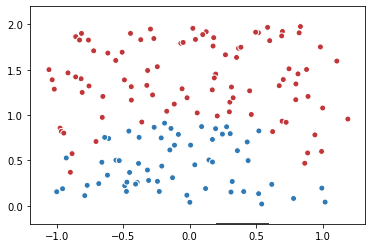

In [9]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 4000#0

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, mse_loss: %f" % (i,sess.run(mse_loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1.2:1.2:0.1, -0.2:2.2:0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]

    probs = sess.run(y, feed_dict={x:grid})

    probs = probs.reshape(xx.shape)

    plt.scatter(data[:,0], data[:,1], c=label,
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")


    plt.contour(xx, yy, probs,levels=[6], cmap="Greys", vmin=0, vmax=.1)
    plt.show()

#### 5. 训练带正则项的损失函数loss。

i 0
i 2000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: No contour levels were found within the data range.


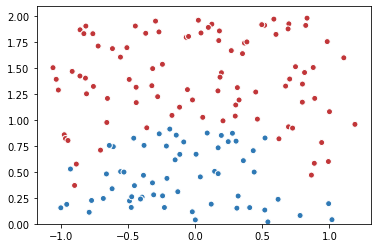

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def get_weight(shape, lambda1):
    var = tf.Variable(tf.random_normal(shape,0.01), dtype=tf.float32)
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var

data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1:
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.01)])
        label.append(1)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.01)])
        label.append(0)
        
data = np.hstack(data).reshape(-1,2).astype(np.float32)
label = np.hstack(label).reshape(-1).astype(np.float32)

x  = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None,))

sample_size = len(data)

# 每层节点的个数
layer_dimension = [2,10,5,3,1]
n_layers = len(layer_dimension)
cur_layer = x
in_dimension = layer_dimension[0]

# 循环生成网络结构
for i in range(1, n_layers):
    out_dimension = layer_dimension[i]
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    cur_layer = tf.nn.relu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y = cur_layer

# 损失函数的定义。
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size
tf.add_to_collection('losses', mse_loss)
loss = tf.add_n(tf.get_collection('losses'))

# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.01).minimize(mse_loss)#loss)
TRAINING_STEPS = 4000


with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        re=sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("i",i)
            #print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

    plt.scatter(data[:,0], data[:,1], c=label,
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
    plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.01)
    plt.show()